# Feature Engineering & Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler,LabelEncoder, MinMaxScaler

### Dataset 1

In [2]:
df_1 = pd.read_csv("AUC.csv")
df_1.head()

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         87489 non-null  object
 1   author       87489 non-null  object
 2   narrator     87489 non-null  object
 3   time         87489 non-null  object
 4   releasedate  87489 non-null  object
 5   language     87489 non-null  object
 6   stars        87489 non-null  object
 7   price        87489 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


 Handling Missing & Duplicated Data

In [4]:
df_1.isnull().sum()

name           0
author         0
narrator       0
time           0
releasedate    0
language       0
stars          0
price          0
dtype: int64

In [5]:
print("Data Duplikat: ", df_1.duplicated().sum())

Data Duplikat:  0


In [6]:
# Fungsi untuk mengonversi time ke jam desimal
def convert_time_to_hours(time_str):
    match = re.findall(r'(\d+)\s*hrs?', time_str)
    hours = int(match[0]) if match else 0
    match = re.findall(r'(\d+)\s*mins?', time_str)
    minutes = int(match[0]) if match else 0
    return hours + (minutes / 60)

df_1['time'] = df_1['time'].apply(convert_time_to_hours)
df_1['releasedate'] = pd.to_datetime(df_1['releasedate'], format='%d-%m-%y')
df_1['stars'] = df_1['stars'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
df_1['price'] = pd.to_numeric(df_1['price'], errors='coerce')

In [7]:
# Feature Engineering
df_1['release_year'] = pd.to_datetime(df_1['releasedate'], format='%d-%m-%y').dt.year
df_1['author'] = df_1['author'].str.replace("Writtenby:", "", regex=True)
df_1['narrator'] = df_1['narrator'].str.replace("Narratedby:", "", regex=True)

In [8]:
# Frequency encoding untuk author dan narrator
author_counts = df_1['author'].value_counts(normalize=True)
narrator_counts = df_1['narrator'].value_counts(normalize=True)

df_1['author_freq'] = df_1['author'].map(author_counts)
df_1['narrator_freq'] = df_1['narrator'].map(narrator_counts)

In [9]:
# Binary encoding untuk language
unique_languages = df_1['language'].unique()
language_map = {lang: idx + 1 for idx, lang in enumerate(unique_languages)}
df_1['language'] = df_1['language'].map(language_map)

In [10]:
df_1.head()

,name,author,narrator,time,releasedate,language,stars,price,release_year,author_freq,narrator_freq
0,Geronimo Stilton #11 & #12,GeronimoStilton,BillLobely,2.333333,2008-08-04,1,5.0,468.0,2008,0.000240,0.000011
1,The Burning Maze,RickRiordan,RobbieDaymond,13.133333,2018-05-01,1,4.5,820.0,2018,0.000537,0.000114
2,The Deep End,JeffKinney,DanRussell,2.050000,2020-11-06,1,4.5,410.0,2020,0.000377,0.000194
3,Daughter of the Deep,RickRiordan,SoneelaNankani,11.266667,2021-10-05,1,4.5,615.0,2021,0.000537,0.000537
4,"The Lightning Thief: Percy Jackson, Book 1",RickRiordan,JesseBernstein,10.000000,2010-01-13,1,4.5,820.0,2010,0.000537,0.000160


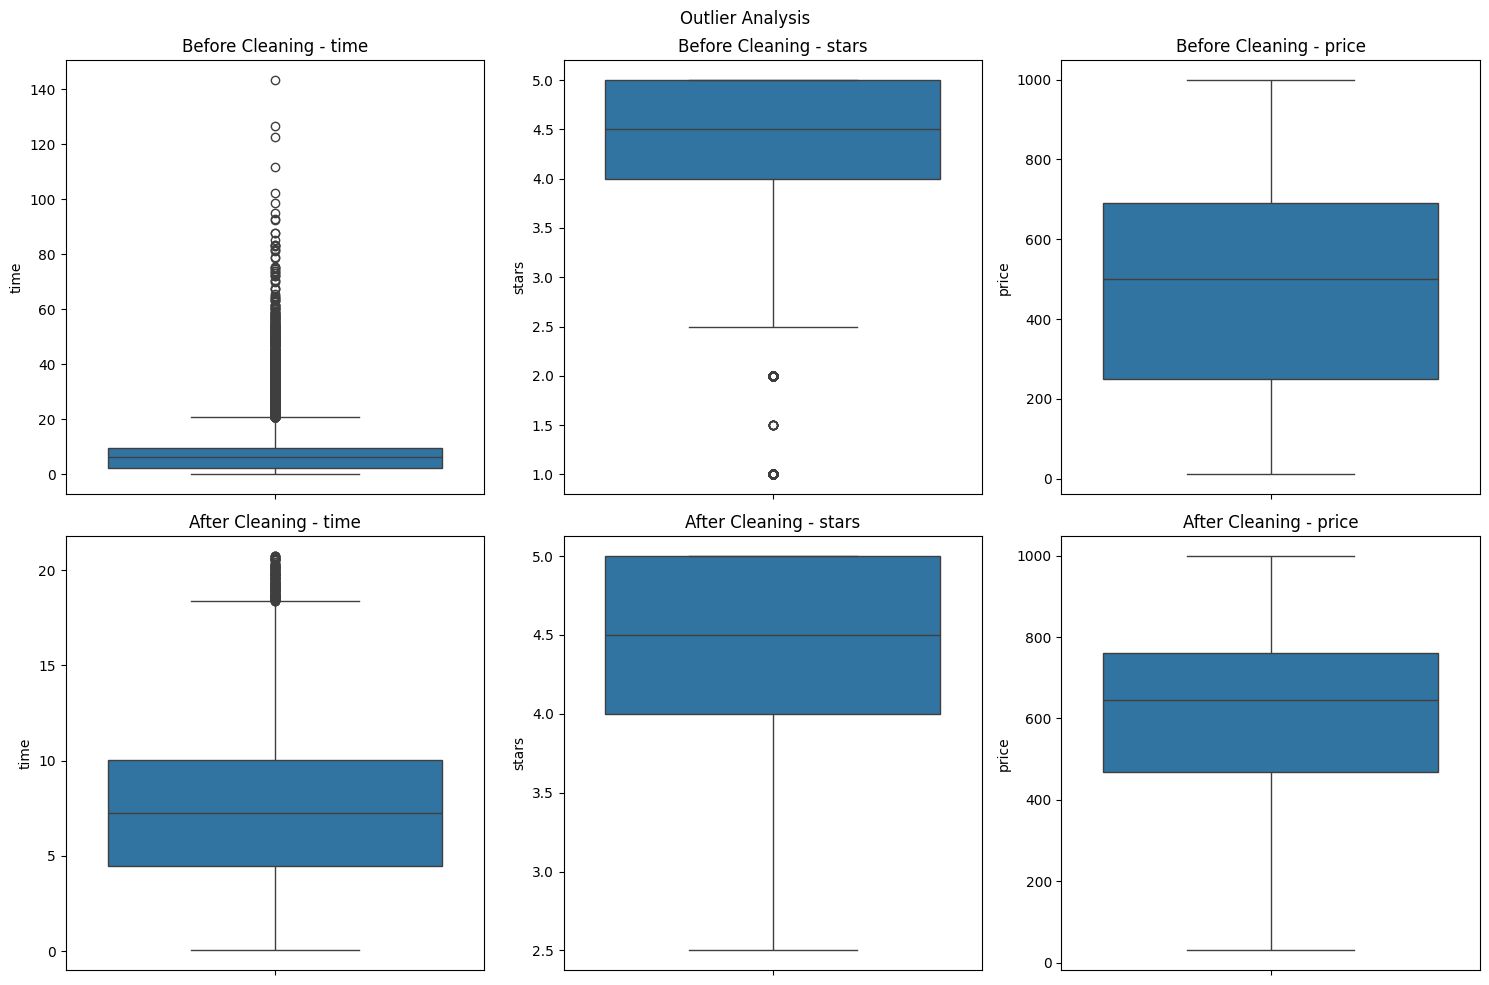

In [11]:
# Outlier Engineering dengan metode IQR
def remove_outliers_iqr(df_1, column):
    Q1 = df_1[column].quantile(0.25)
    Q3 = df_1[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_1[(df_1[column] >= lower_bound) & (df_1[column] <= upper_bound)]

# Visualisasi Outliers sebelum dan sesudah pembersihan
numeric_columns = ['time', 'stars', 'price']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Outlier Analysis")

# Sebelum pembersihan
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=df_1[col], ax=axes[0, i])
    axes[0, i].set_title(f"Before Cleaning - {col}")

# Menghapus outliers
for col in numeric_columns:
    df_1 = remove_outliers_iqr(df_1, col)

# Sesudah pembersihan
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=df_1[col], ax=axes[1, i])
    axes[1, i].set_title(f"After Cleaning - {col}")

plt.tight_layout()
plt.show()


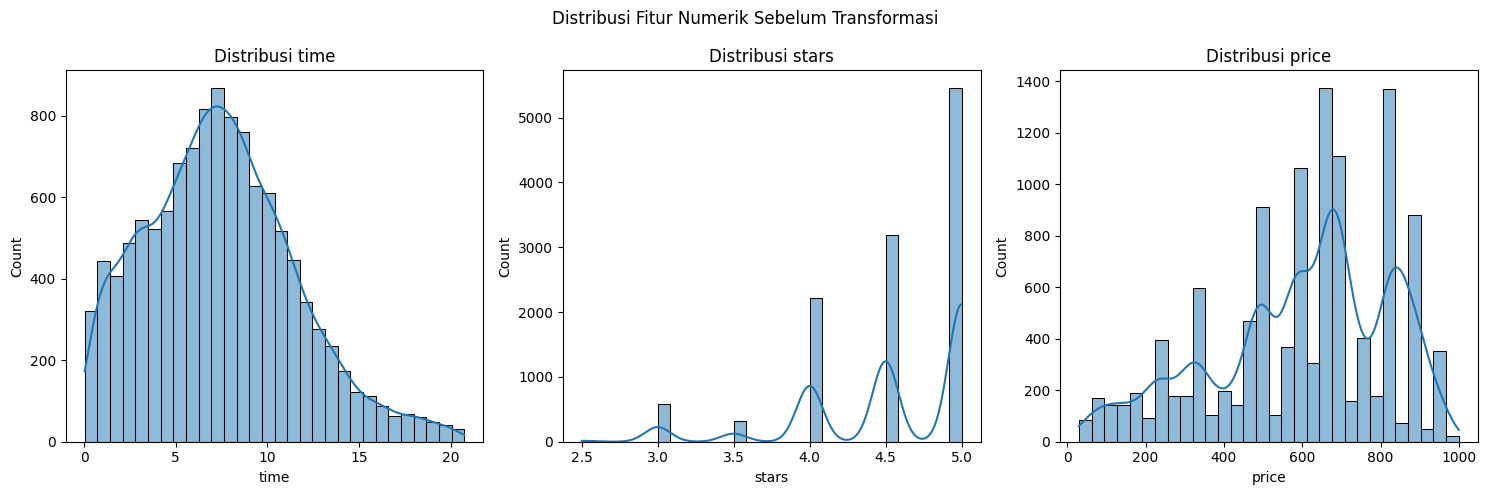

In [12]:
# Menampilkan histogram sebelum transformasi
numeric_columns = ['time', 'stars', 'price']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribusi Fitur Numerik Sebelum Transformasi")
for i, col in enumerate(numeric_columns):
    sns.histplot(df_1[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribusi {col}")
plt.tight_layout()
plt.show()

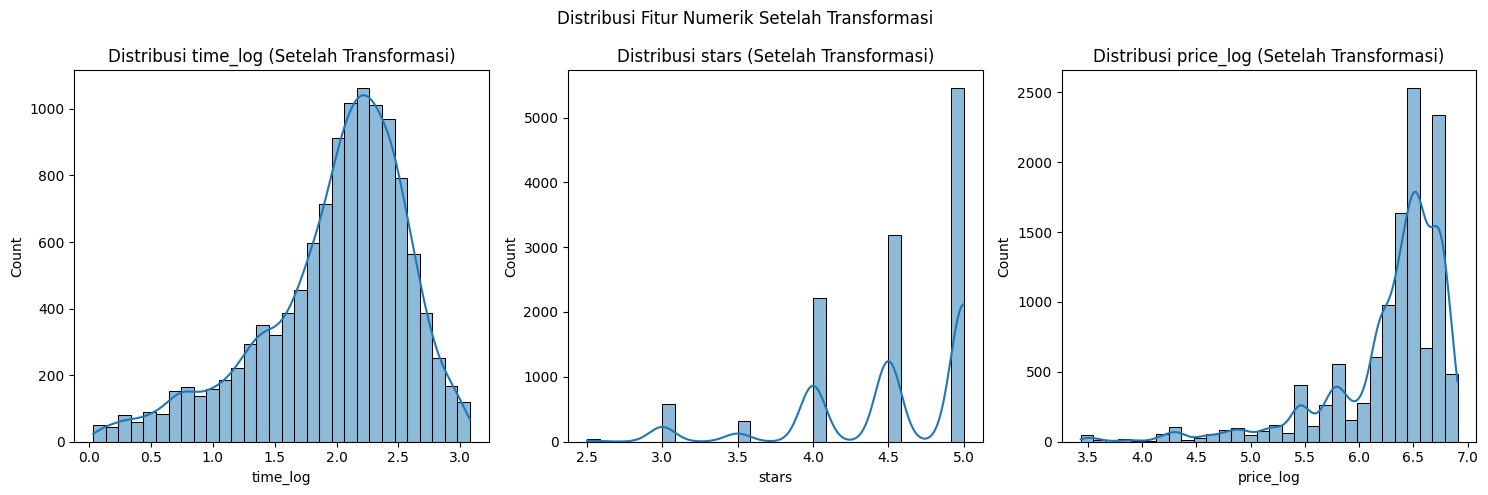

In [13]:
# Variable Transformation
# Menerapkan Log Transformation untuk fitur yang skewed
df_1['time_log'] = np.log1p(df_1['time'])
df_1['price_log'] = np.log1p(df_1['price'])

# Feature Scaling
scaler = StandardScaler()
df_1[['time_scaled', 'stars_scaled', 'price_scaled']] = scaler.fit_transform(df_1[['time_log', 'stars', 'price_log']])

# Menampilkan histogram setelah transformasi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribusi Fitur Numerik Setelah Transformasi")
for i, col in enumerate(['time_log', 'stars', 'price_log']):
    sns.histplot(df_1[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribusi {col} (Setelah Transformasi)")
plt.tight_layout()
plt.show()

### Dataset 2

In [14]:
df_2 = pd.read_csv("FDC.csv")
df_2.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,2.4,2,1,430,NaN,315.0,1,none,we dont have comfort,9.0,...,1.0,1.0,1,1165.0,345,car racing,5,1,1315,187
1,3.654,1,1,610,3.0,420.0,2,"chocolate, chips, ice cream","Stress, bored, anger",1.0,...,1.0,1.0,2,725.0,690,Basketball,4,2,900,155
2,3.3,1,1,720,4.0,420.0,2,"frozen yogurt, pizza, fast food","stress, sadness",1.0,...,1.0,2.0,5,1165.0,500,none,5,1,900,I'm not answering this.
3,3.2,1,1,430,3.0,420.0,2,"Pizza, Mac and cheese, ice cream",Boredom,2.0,...,1.0,2.0,5,725.0,690,NaN,3,1,1315,"Not sure, 240"
4,3.5,1,1,720,2.0,420.0,2,"Ice cream, chocolate, chips","Stress, boredom, cravings",1.0,...,1.0,1.0,4,940.0,500,Softball,4,2,760,190


In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   GPA                           123 non-null    object 
 1   Gender                        125 non-null    int64  
 2   breakfast                     125 non-null    int64  
 3   calories_chicken              125 non-null    int64  
 4   calories_day                  106 non-null    float64
 5   calories_scone                124 non-null    float64
 6   coffee                        125 non-null    int64  
 7   comfort_food                  124 non-null    object 
 8   comfort_food_reasons          123 non-null    object 
 9   comfort_food_reasons_coded    106 non-null    float64
 10  cook                          122 non-null    float64
 11  comfort_food_reasons_coded.1  125 non-null    int64  
 12  cuisine                       108 non-null    float64
 13  diet_

In [16]:
print("Data Duplikat: ", df_2.duplicated().sum())

Data Duplikat:  0


In [17]:
df_2['GPA'] = df_2['GPA'].str.extract(r'(\d+\.?\d*)').astype(float)
df_2['weight'] = df_2['weight'].str.extract(r'(\d+)').astype(float)

In [18]:
df_2.isnull().sum()

GPA                  4
Gender               0
breakfast            0
calories_chicken     0
calories_day        19
                    ..
type_sports         26
veggies_day          0
vitamins             0
waffle_calories      0
weight               3
Length: 61, dtype: int64

In [19]:
# Mengisi Missing Values
# Menggunakan Median untuk data numerik yang bisa memiliki outlier
df_2.fillna({'GPA': df_2['GPA'].median(),
           'calories_day': df_2['calories_day'].median(),
           'exercise': df_2['exercise'].median(),
           'sports': df_2['sports'].median(),
           'weight': df_2['weight'].median()}, inplace=True)

# Menggunakan Mode untuk data kategorikal
df_2.fillna({'diet_current': df_2['diet_current'].mode()[0],
           'father_profession': df_2['father_profession'].mode()[0],
           'type_sports': df_2['type_sports'].mode()[0]}, inplace=True)

In [20]:
df_2.isnull().sum()

GPA                 0
Gender              0
breakfast           0
calories_chicken    0
calories_day        0
                   ..
type_sports         0
veggies_day         0
vitamins            0
waffle_calories     0
weight              0
Length: 61, dtype: int64

In [21]:
# Encoding Categorical Variables
df_2['type_sports'] = LabelEncoder().fit_transform(df_2['type_sports'])

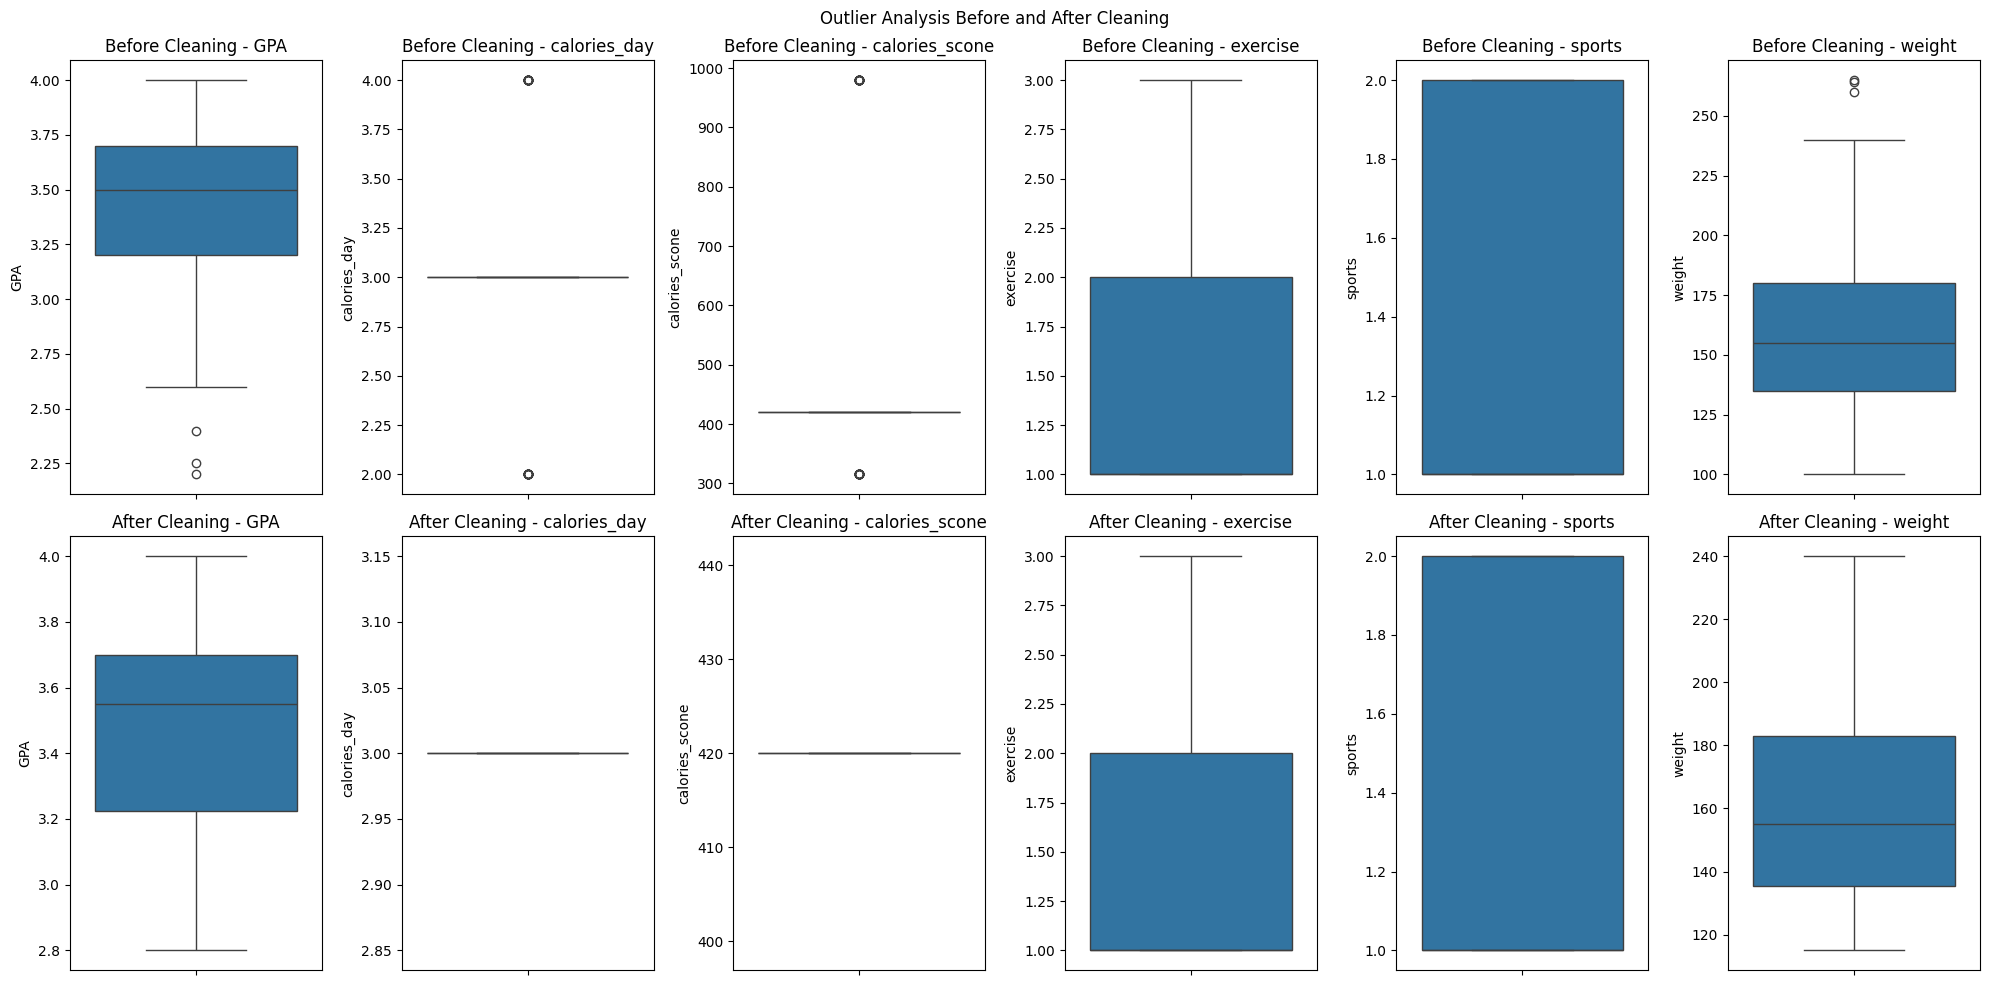

In [22]:
# Outlier Engineering
def remove_outliers_iqr(df_2, column):
    Q1 = df_2[column].quantile(0.25)
    Q3 = df_2[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_2[(df_2[column] >= lower_bound) & (df_2[column] <= upper_bound)]

numeric_columns = ['GPA', 'calories_day', 'calories_scone', 'exercise', 'sports', 'weight']

# Visualisasi Outliers Sebelum dan Sesudah Pembersihan
fig, axes = plt.subplots(2, len(numeric_columns), figsize=(20, 10))
fig.suptitle("Outlier Analysis Before and After Cleaning")

# Sebelum pembersihan
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=df_2[col], ax=axes[0, i])
    axes[0, i].set_title(f"Before Cleaning - {col}")

# Menghapus outliers
df_cleaned = df_2.copy()
for col in numeric_columns:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

# Sesudah pembersihan
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=df_cleaned[col], ax=axes[1, i])
    axes[1, i].set_title(f"After Cleaning - {col}")

plt.tight_layout()
plt.show()

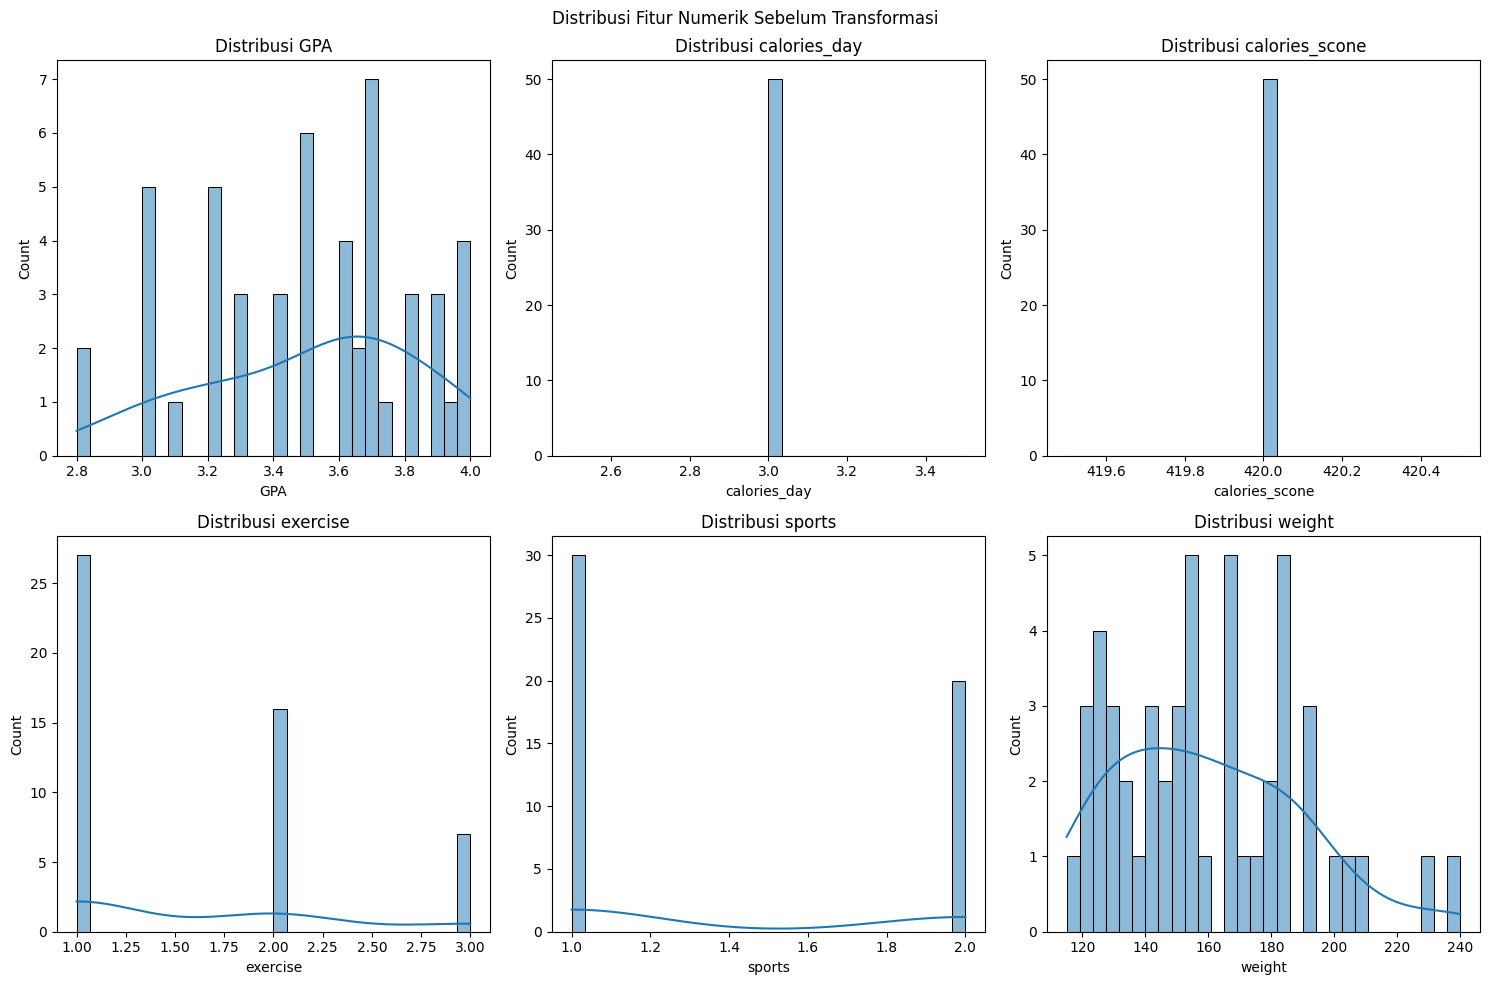

In [23]:
# Visualisasi Histogram Sebelum Transformasi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribusi Fitur Numerik Sebelum Transformasi")
for i, col in enumerate(numeric_columns):
    sns.histplot(df_cleaned[col].dropna(), bins=30, kde=True, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f"Distribusi {col}")
plt.tight_layout()
plt.show()

In [24]:
# Feature Scaling
scaler = StandardScaler()
df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])

# Variable Transformation
for col in numeric_columns:
    df_cleaned[col + '_log'] = np.log1p(df_cleaned[col])

c:\Users\Nisa\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Nisa\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


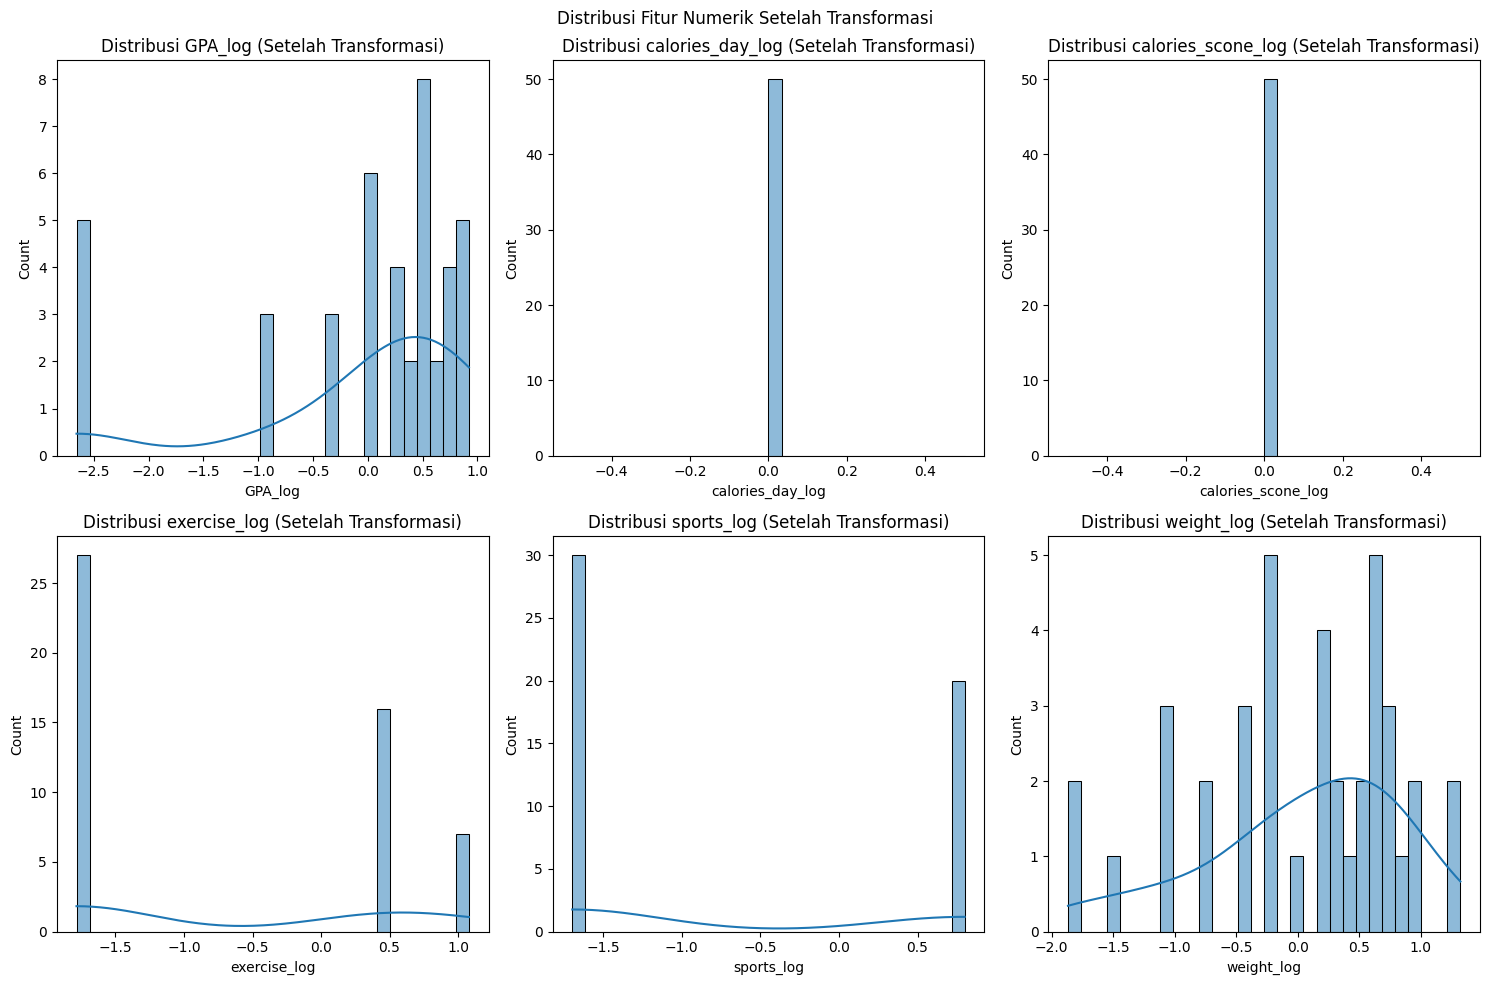

In [25]:
# Visualisasi Histogram Setelah Transformasi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribusi Fitur Numerik Setelah Transformasi")
for i, col in enumerate([col + '_log' for col in numeric_columns]):
    sns.histplot(df_cleaned[col].dropna(), bins=30, kde=True, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f"Distribusi {col} (Setelah Transformasi)")
plt.tight_layout()
plt.show()

### Dataset 3

In [26]:
df_3 = pd.read_csv("LTP.csv", encoding="ISO-8859-1")
df_3.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [27]:
print("Data Duplikat: ", df_3.duplicated().sum())

Data Duplikat:  0


In [28]:
df_3.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [29]:
# Konversi 'Ram' & 'Weight' ke numerik
df_3['Ram'] = df_3['Ram'].str.replace('GB', '').astype(int)
df_3['Weight'] = df_3['Weight'].str.replace('kg', '').astype(float)

In [30]:
# Ekstraksi informasi dari 'ScreenResolution'
df_3['Touchscreen'] = df_3['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df_3['IPS_Panel'] = df_3['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)
df_3['Resolution'] = df_3['ScreenResolution'].str.extract(r'(\d+x\d+)')

df_3[['X_res', 'Y_res']] = df_3['Resolution'].str.split('x', expand=True).astype(float)
df_3['Total_Pixels'] = df_3['X_res'] * df_3['Y_res']
df_3['Aspect_Ratio'] = df_3['X_res'] / df_3['Y_res']

In [31]:
# Ekstraksi informasi dari 'Cpu' & 'Gpu'
df_3['Cpu_Brand'] = df_3['Cpu'].apply(lambda x: x.split()[0])
df_3['Cpu_Speed_GHz'] = df_3['Cpu'].str.extract(r'(\d+\.\d+)').astype(float)
df_3['Gpu_Brand'] = df_3['Gpu'].apply(lambda x: x.split()[0])

# Kategorisasi 'OpSys'
def categorize_os(os):
    if 'Windows' in os:
        return 'Windows'
    elif 'Mac' in os or 'macOS' in os:
        return 'MacOS'
    elif 'Linux' in os:
        return 'Linux'
    else:
        return 'Other'

df_3['OpSys_Category'] = df_3['OpSys'].apply(categorize_os)


In [32]:
# Encoding Categorical Variables
label_encode_cols = ['Cpu_Brand', 'Gpu_Brand', 'OpSys_Category']
for col in label_encode_cols:
    df_3[col] = LabelEncoder().fit_transform(df_3[col])

df = pd.get_dummies(df_3, columns=['Company', 'TypeName'], drop_first=True)

In [33]:
# Hapus kolom yang tidak diperlukan
df_3.drop(columns=['ScreenResolution', 'Cpu', 'Gpu', 'Memory', 'Resolution'], inplace=True)

In [34]:
df_3.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,IPS_Panel,X_res,Y_res,Total_Pixels,Aspect_Ratio,Cpu_Brand,Cpu_Speed_GHz,Gpu_Brand,OpSys_Category
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,0,1,2560.0,1600.0,4096000.0,1.600000,1,2.3,2,1
1,2,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,0,0,1440.0,900.0,1296000.0,1.600000,1,1.8,2,1
2,3,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,0,0,1920.0,1080.0,2073600.0,1.777778,1,2.5,2,2
3,4,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,0,1,2880.0,1800.0,5184000.0,1.600000,1,2.7,0,1
4,5,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,0,1,2560.0,1600.0,4096000.0,1.600000,1,3.1,2,1


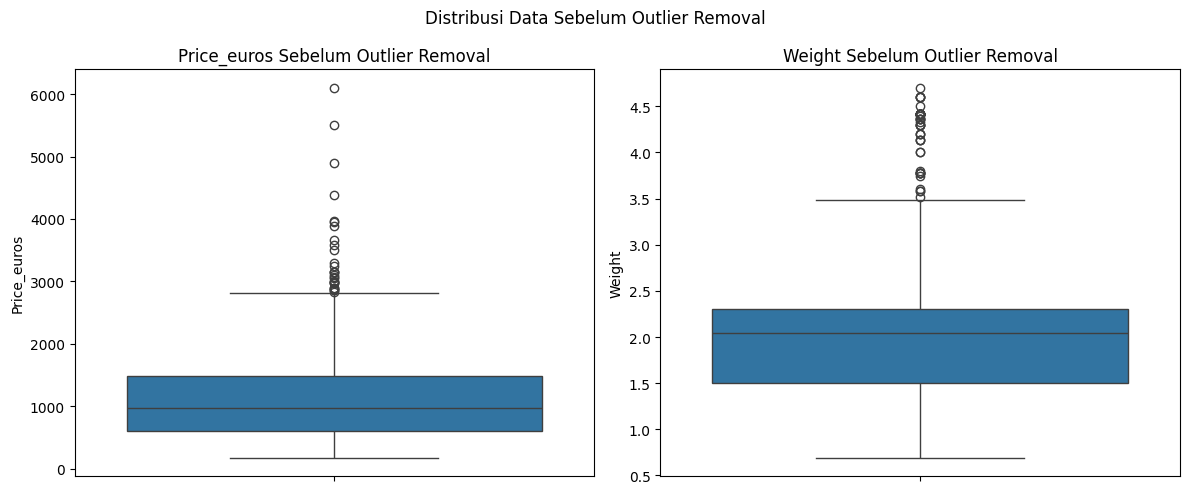

In [35]:
# Visualisasi distribusi sebelum outlier removal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distribusi Data Sebelum Outlier Removal")

for i, col in enumerate(['Price_euros', 'Weight']):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} Sebelum Outlier Removal")

plt.tight_layout()
plt.show()

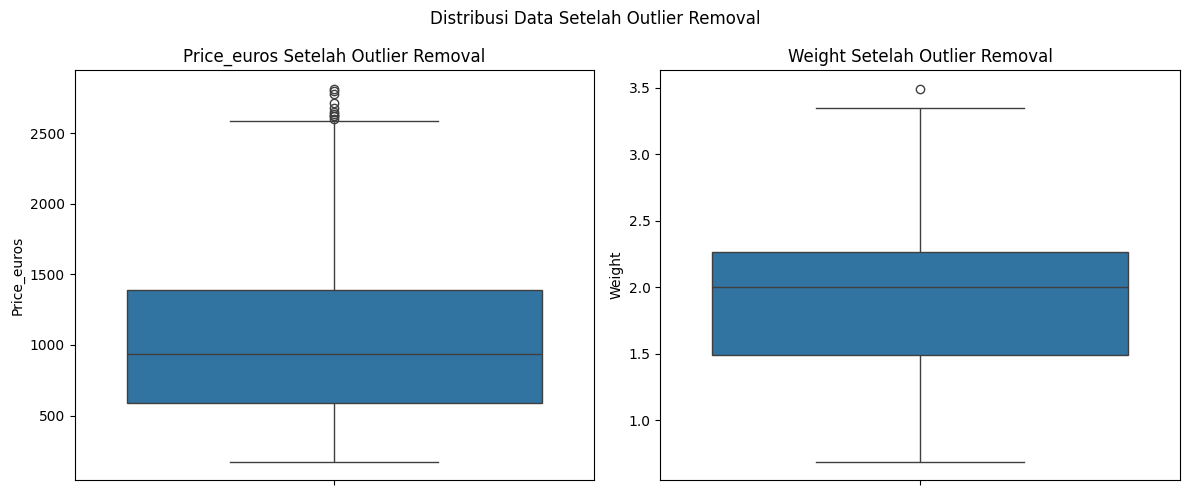

In [36]:
# Outlier Engineering

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Membuat salinan dataset sebelum membersihkan outlier
df_cleaned = df.copy()

# Menghapus outliers dari Price_euros dan Weight
for col in ['Price_euros', 'Weight']:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

# Visualisasi distribusi setelah outlier removal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distribusi Data Setelah Outlier Removal")

for i, col in enumerate(['Price_euros', 'Weight']):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])
    axes[i].set_title(f"{col} Setelah Outlier Removal")

plt.tight_layout()
plt.show()

In [37]:
# Variable Transformation (Log Transform for Skewed Data)
df_cleaned['Price_euros_log'] = np.log1p(df_cleaned['Price_euros'])

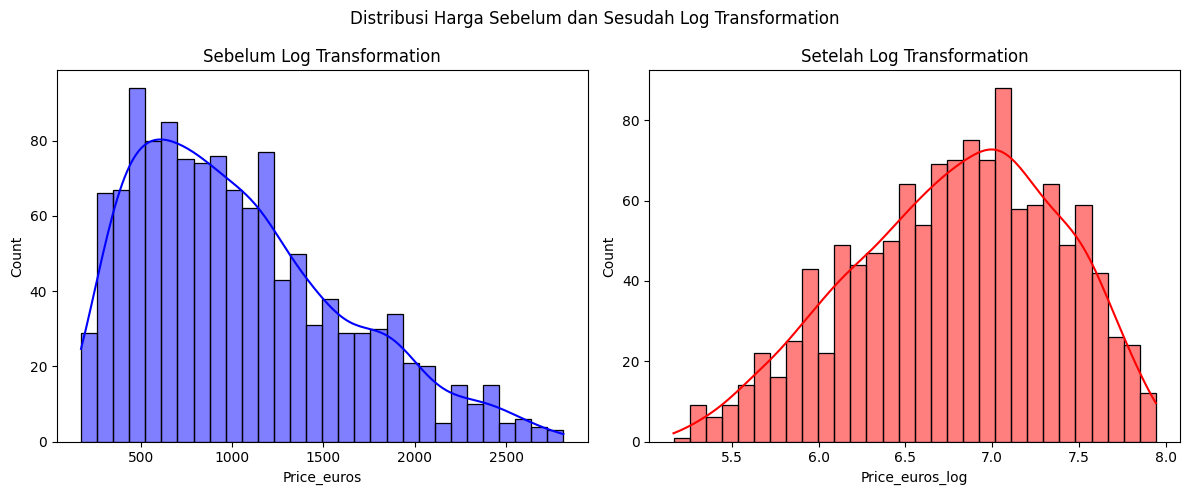

In [38]:
# Visualisasi distribusi sebelum dan sesudah Log Transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distribusi Harga Sebelum dan Sesudah Log Transformation")

sns.histplot(df_cleaned['Price_euros'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Sebelum Log Transformation")

sns.histplot(df_cleaned['Price_euros_log'], bins=30, kde=True, color='red', ax=axes[1])
axes[1].set_title("Setelah Log Transformation")

plt.tight_layout()
plt.show()

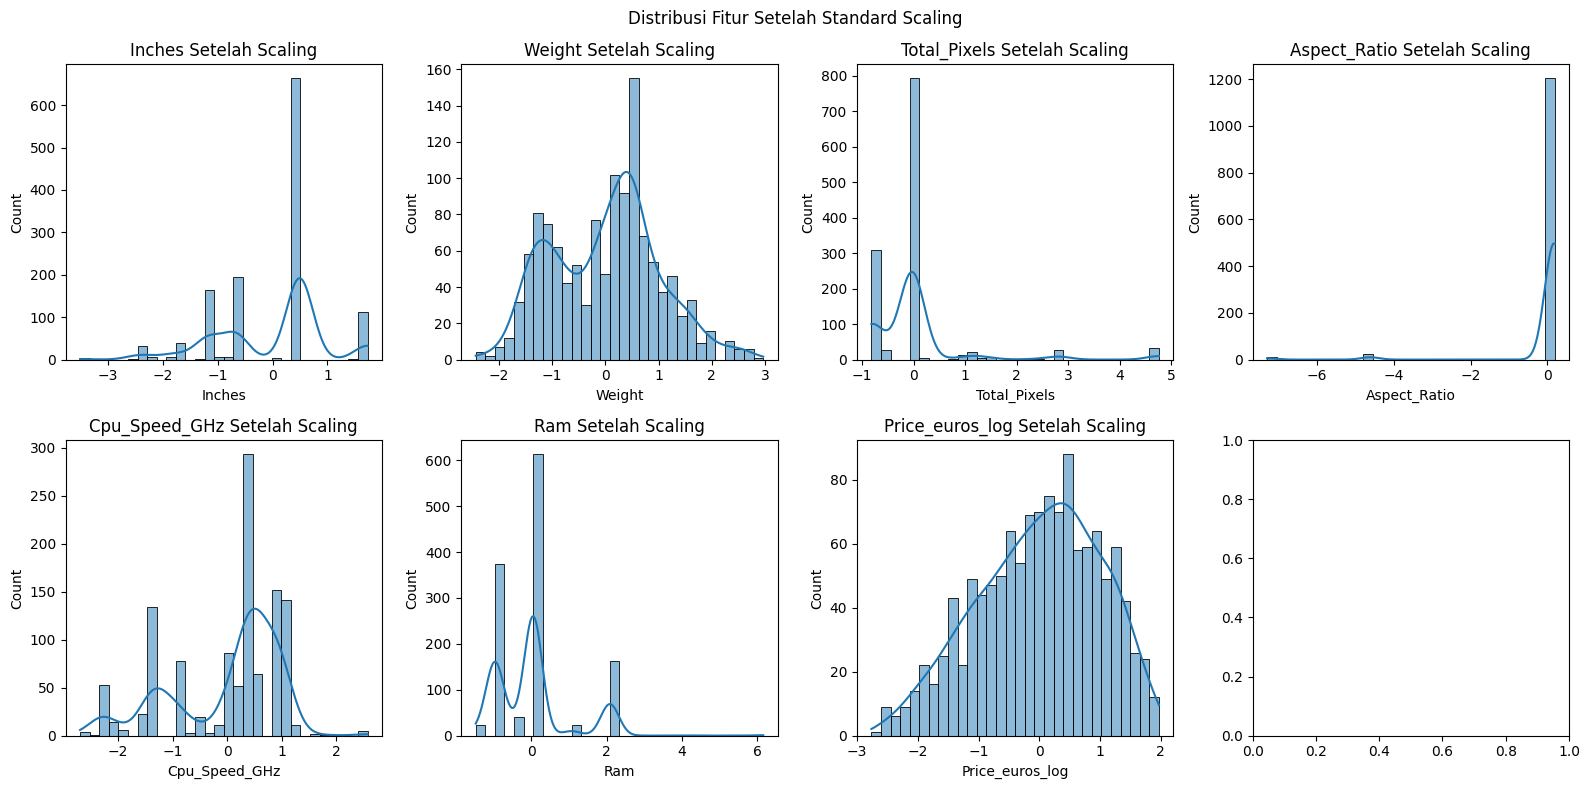

In [39]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
numeric_cols = ['Inches', 'Weight', 'Total_Pixels', 'Aspect_Ratio', 'Cpu_Speed_GHz', 'Ram', 'Price_euros_log']
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Visualisasi distribusi setelah Feature Scaling
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Distribusi Fitur Setelah Standard Scaling")

for i, col in enumerate(numeric_cols):
    sns.histplot(df_cleaned[col], bins=30, kde=True, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f"{col} Setelah Scaling")

plt.tight_layout()
plt.show()

### Dataset 4

In [40]:
df_4 = pd.read_csv("SHP.csv")
df_4.head()

,Unnamed: 0,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
1,1,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
2,2,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
3,3,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
4,4,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,inf,Candra Jacostaffey,True


In [41]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12138 entries, 0 to 12137
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12138 non-null  int64 
 1   PassengerId   12138 non-null  object
 2   HomePlanet    11985 non-null  object
 3   CryoSleep     11955 non-null  object
 4   Cabin         11982 non-null  object
 5   Destination   11981 non-null  object
 6   Age           11993 non-null  object
 7   VIP           11963 non-null  object
 8   RoomService   12002 non-null  object
 9   FoodCourt     11991 non-null  object
 10  ShoppingMall  11964 non-null  object
 11  Spa           11985 non-null  object
 12  VRDeck        11975 non-null  object
 13  Name          11973 non-null  object
 14  Transported   12138 non-null  bool  
dtypes: bool(1), int64(1), object(13)
memory usage: 1.3+ MB


In [42]:
# Mengonversi kolom numerik yang masih dalam format string menjadi numerik
df_4[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df_4[
    ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
].apply(pd.to_numeric, errors='coerce')

In [43]:
# Menangani nilai inf pada kolom VRDeck
df_4.replace([np.inf, -np.inf], np.nan, inplace=True)
df_4['VRDeck'].fillna(df_4['VRDeck'].median(), inplace=True)

C:\Users\Nisa\AppData\Local\Temp\ipykernel_15224\2176798708.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_4['VRDeck'].fillna(df_4['VRDeck'].median(), inplace=True)


In [44]:
print("Data Duplikat: ", df_4.duplicated().sum())

Data Duplikat:  0


In [45]:
df_4.isnull().sum()

Unnamed: 0        0
PassengerId       0
HomePlanet      153
CryoSleep       183
Cabin           156
Destination     157
Age             247
VIP             175
RoomService     234
FoodCourt       254
ShoppingMall    291
Spa             247
VRDeck            0
Name            165
Transported       0
dtype: int64

In [46]:
# Handling Missing
df_4.drop(columns=['Unnamed: 0', 'PassengerId', 'Name'], inplace=True)

In [47]:
# Mengisi kategori dengan mode (nilai yang paling sering muncul)
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin', 'Transported']
df_4.fillna({col: df_4[col].mode()[0] for col in categorical_cols}, inplace=True)

In [48]:
# Mengisi numerik dengan median (agar tidak terpengaruh outliers)
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_4.fillna({col: df_4[col].median() for col in numeric_cols}, inplace=True)

In [49]:
df_4.isnull().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [50]:
df_4['CryoSleep'] = df_4['CryoSleep'].astype(str).map({'True': 1, 'False': 0, 'nan': 0}).fillna(0).astype(int)
df_4['VIP'] = df_4['VIP'].astype(str).map({'True': 1, 'False': 0, 'nan': 0}).fillna(0).astype(int)
df_4['Transported'] = df_4['Transported'].astype(int)

In [51]:
# Mengekstrak informasi dari Cabin (Deck, Side)
df_4[['Deck', 'Cabin_Num', 'Side']] = df_4['Cabin'].str.split('/', expand=True)
df_4.drop(columns=['Cabin'], inplace=True)

In [52]:
df_4['Cabin_Num'] = pd.to_numeric(df_4['Cabin_Num'], errors='coerce')

In [53]:
# Feature Engineering
label_encode_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
for col in label_encode_cols:
    df_4[col] = LabelEncoder().fit_transform(df_4[col])
df_4['Total_Spending'] = df_4[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [54]:
df_4.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_Num,Side,Total_Spending
0,2,0,4,24.0,0,109.0,9.0,25.0,549.0,44.0,1,7,0.0,1,736.0
1,2,0,4,16.0,0,303.0,70.0,151.0,565.0,2.0,1,7,1.0,1,1091.0
2,2,0,3,44.0,0,0.0,483.0,0.0,291.0,0.0,1,7,0.0,0,774.0
3,2,0,4,26.0,0,42.0,1539.0,3.0,0.0,0.0,1,7,2.0,1,1584.0
4,2,1,4,28.0,0,0.0,0.0,0.0,0.0,0.0,1,8,0.0,1,0.0


In [55]:
# Outlier Engineering
def remove_outliers_iqr(df, column):
    if column not in df.columns:
        print(f"Warning: {column} tidak ditemukan dalam dataset.")
        return df
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = df_4.copy()
outlier_cols = ['Age', 'Total_Spending']

In [56]:
# Outlier Engineering
def remove_outliers_iqr(df_4, column):
    if column not in df_4.columns:
        print(f"Warning: {column} tidak ditemukan dalam dataset.")
        return df_4
    Q1 = df_4[column].quantile(0.25)
    Q3 = df_4[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_4[(df_4[column] >= lower_bound) & (df_4[column] <= upper_bound)]

df_cleaned = df_4.copy()
outlier_cols = ['Age', 'Total_Spending']


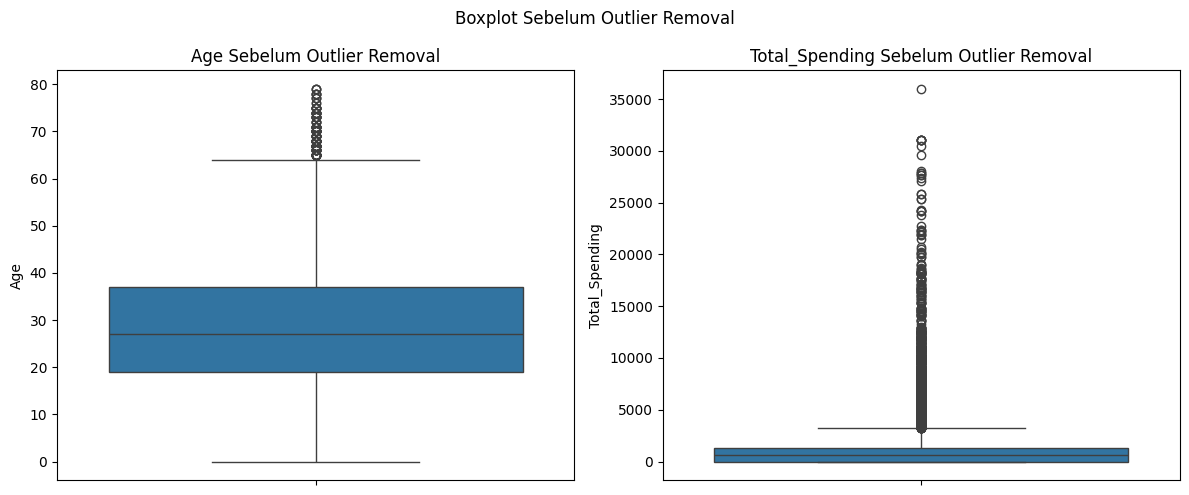

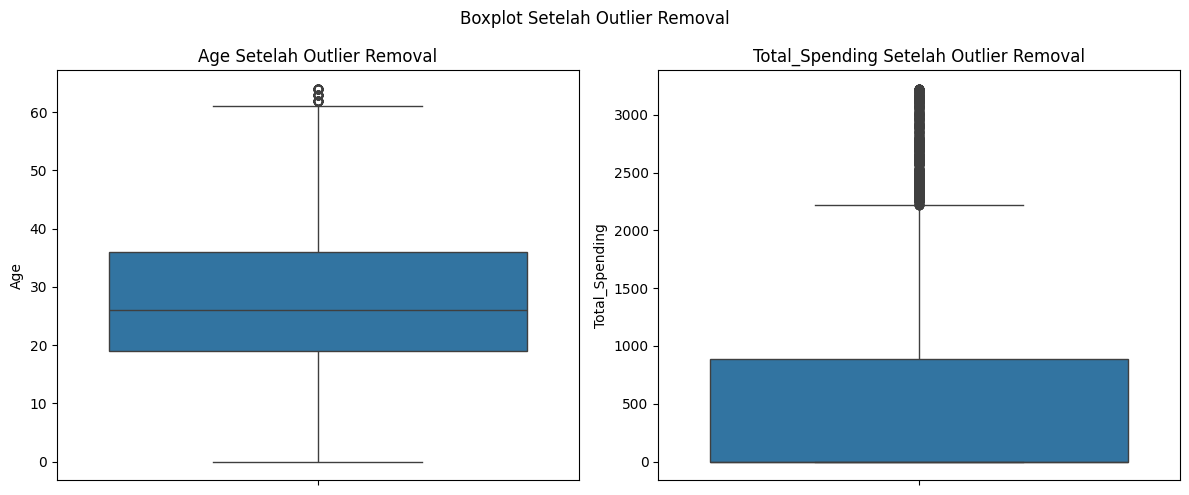

In [57]:
# Visualisasi sebelum penghapusan outlier
if len(outlier_cols) > 0:
    fig, axes = plt.subplots(1, len(outlier_cols), figsize=(6 * len(outlier_cols), 5))
    fig.suptitle("Boxplot Sebelum Outlier Removal")
    if len(outlier_cols) == 1:
        axes = [axes]
    for i, col in enumerate(outlier_cols):
        sns.boxplot(y=df_4[col], ax=axes[i])
        axes[i].set_title(f"{col} Sebelum Outlier Removal")
    plt.tight_layout()
    plt.show()

# Menghapus outliers
df_cleaned = df_4.copy()
for col in outlier_cols:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

# Visualisasi setelah penghapusan outlier
if len(outlier_cols) > 0:
    fig, axes = plt.subplots(1, len(outlier_cols), figsize=(6 * len(outlier_cols), 5))
    fig.suptitle("Boxplot Setelah Outlier Removal")
    if len(outlier_cols) == 1:
        axes = [axes]
    for i, col in enumerate(outlier_cols):
        sns.boxplot(y=df_cleaned[col], ax=axes[i])
        axes[i].set_title(f"{col} Setelah Outlier Removal")
    plt.tight_layout()
    plt.show()

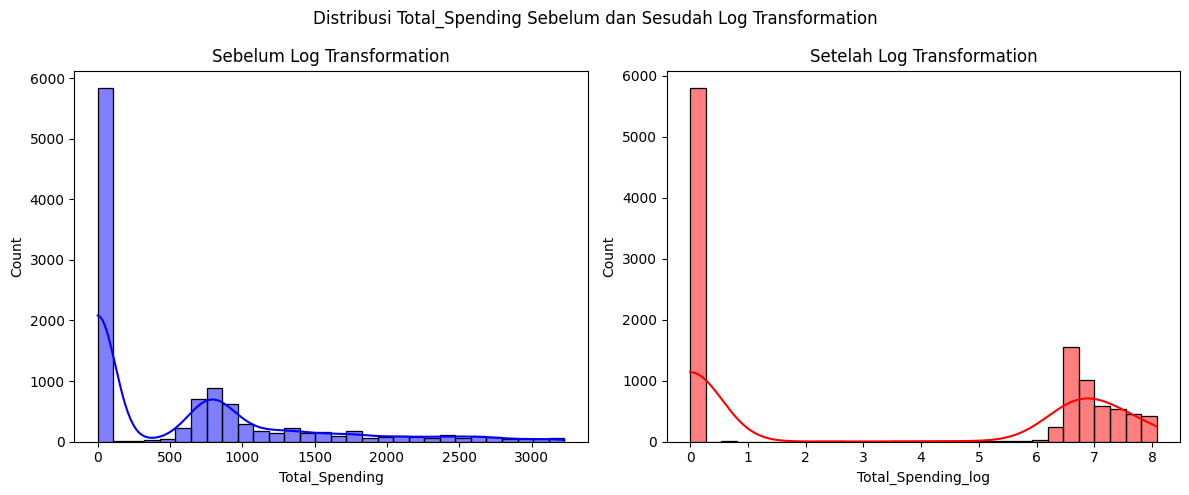

In [58]:
# Variable Transformation (Log Transform)
df_cleaned['Total_Spending_log'] = np.log1p(df_cleaned['Total_Spending'])

# Visualisasi distribusi sebelum dan sesudah Log Transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distribusi Total_Spending Sebelum dan Sesudah Log Transformation")
sns.histplot(df_cleaned['Total_Spending'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Sebelum Log Transformation")
sns.histplot(df_cleaned['Total_Spending_log'], bins=30, kde=True, color='red', ax=axes[1])
axes[1].set_title("Setelah Log Transformation")
plt.tight_layout()
plt.show()

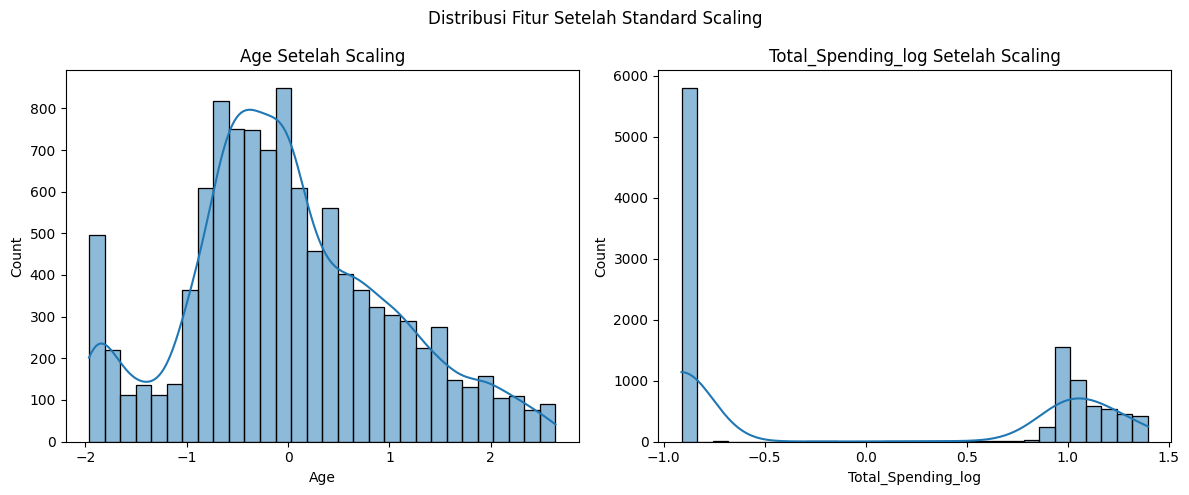

In [59]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
numeric_cols = ['Age', 'Total_Spending_log']
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Visualisasi distribusi setelah Feature Scaling
if len(numeric_cols) > 0:
    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(6 * len(numeric_cols), 5))
    fig.suptitle("Distribusi Fitur Setelah Standard Scaling")
    if len(numeric_cols) == 1:
        axes = [axes]
    for i, col in enumerate(numeric_cols):
        sns.histplot(df_cleaned[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"{col} Setelah Scaling")
    plt.tight_layout()
    plt.show()

### Dataset 5

In [60]:
df_5 = pd.read_csv("MBP.csv")
df_5.head()

,Phone Name,Rating ?/5,Number of Ratings,RAM,ROM/Storage,Back/Rare Camera,Front Camera,Battery,Processor,Price in INR,Date of Scraping
0,"POCO C50 (Royal Blue, 32 GB)",4.2,"33,561",2 GB RAM,32 GB ROM,8MP Dual Camera,5MP Front Camera,5000 mAh,"Mediatek Helio A22 Processor, Upto 2.0 GHz Pro...","₹5,649",2023-06-17
1,"POCO M4 5G (Cool Blue, 64 GB)",4.2,"77,128",4 GB RAM,64 GB ROM,50MP + 2MP,8MP Front Camera,5000 mAh,Mediatek Dimensity 700 Processor,"₹11,999",2023-06-17
2,"POCO C51 (Royal Blue, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17
3,"POCO C55 (Cool Blue, 64 GB)",4.2,"22,621",4 GB RAM,64 GB ROM,50MP Dual Rear Camera,5MP Front Camera,5000 mAh,Mediatek Helio G85 Processor,"₹7,749",2023-06-17
4,"POCO C51 (Power Black, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17


In [61]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Phone Name         1836 non-null   object 
 1   Rating ?/5         1836 non-null   float64
 2   Number of Ratings  1836 non-null   object 
 3   RAM                1836 non-null   object 
 4   ROM/Storage        1662 non-null   object 
 5   Back/Rare Camera   1827 non-null   object 
 6   Front Camera       1435 non-null   object 
 7   Battery            1826 non-null   object 
 8   Processor          1781 non-null   object 
 9   Price in INR       1836 non-null   object 
 10  Date of Scraping   1836 non-null   object 
dtypes: float64(1), object(10)
memory usage: 157.9+ KB


In [62]:
# Convert numerical columns to appropriate data types
df_5['Rating'] = pd.to_numeric(df_5['Rating ?/5'], errors='coerce')
df_5['Number of Ratings'] = df_5['Number of Ratings'].replace(',', '', regex=True).astype(float)
df_5['Price in INR'] = df_5['Price in INR'].replace('[₹,]', '', regex=True).astype(float)

In [63]:
print("Data Duplikat: ", df_5.duplicated().sum())

Data Duplikat:  69


In [64]:
df_5.drop_duplicates(inplace=True)

In [65]:
print("Data Duplikat setelah drop: ", df_5.duplicated().sum())

Data Duplikat setelah drop:  0


In [66]:
df_5.isnull().sum()

Phone Name             0
Rating ?/5             0
Number of Ratings      0
RAM                    0
ROM/Storage          162
Back/Rare Camera       8
Front Camera         381
Battery                9
Processor             49
Price in INR           0
Date of Scraping       0
Rating                 0
dtype: int64

In [67]:
categorical_cols = ['Phone Name', 'RAM', 'ROM/Storage', 'Back/Rare Camera', 'Front Camera', 'Battery', 'Processor']
numerical_cols = ['Rating', 'Number of Ratings', 'Price in INR']

df_5.fillna({col: df_5[col].mode()[0] for col in categorical_cols}, inplace=True)
df_5.fillna({col: df_5[col].mean() for col in numerical_cols}, inplace=True)

In [68]:
df_5.isnull().sum()

Phone Name           0
Rating ?/5           0
Number of Ratings    0
RAM                  0
ROM/Storage          0
Back/Rare Camera     0
Front Camera         0
Battery              0
Processor            0
Price in INR         0
Date of Scraping     0
Rating               0
dtype: int64

In [69]:
# Categorical Encoding
if 'Processor' in df_5.columns:
    label_encoder = LabelEncoder()
    df_5['Processor Encoded'] = label_encoder.fit_transform(df_5['Processor'])

In [70]:
# Date Time Feature Extraction
df_5['Year of Scraping'] = pd.to_datetime(df_5['Date of Scraping']).dt.year

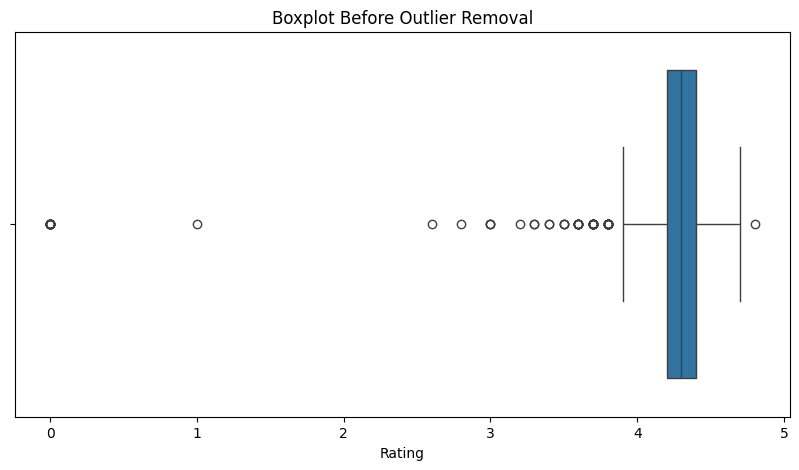

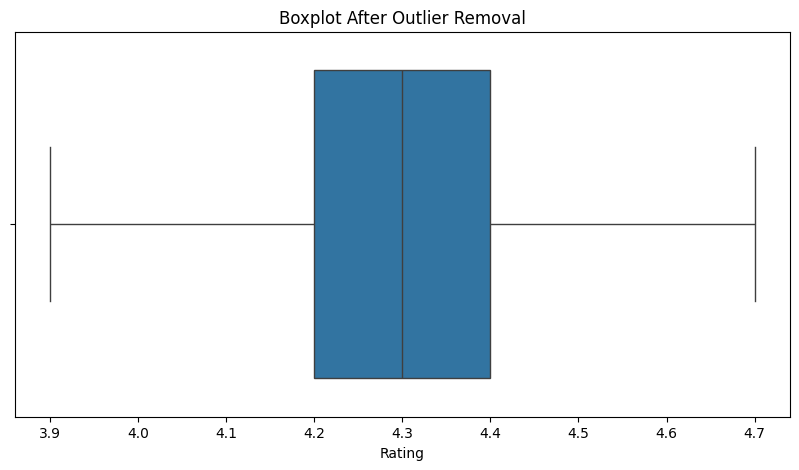

In [71]:
# Outliers Engineering using IQR
plt.figure(figsize=(10,5))
sns.boxplot(x=df_5['Rating'])
plt.title("Boxplot Before Outlier Removal")
plt.show()

Q1 = df_5['Rating'].quantile(0.25)
Q3 = df_5['Rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_5 = df_5[(df_5['Rating'] >= lower_bound) & (df_5['Rating'] <= upper_bound)]

plt.figure(figsize=(10,5))
sns.boxplot(x=df_5['Rating'])
plt.title("Boxplot After Outlier Removal")
plt.show()


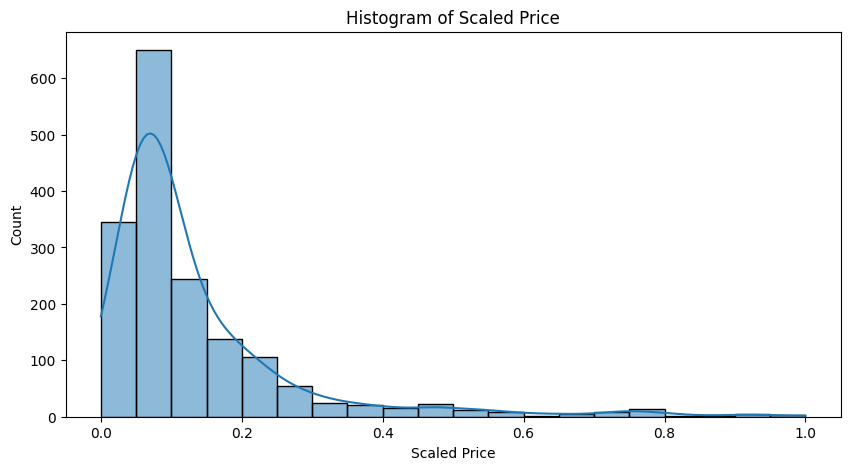

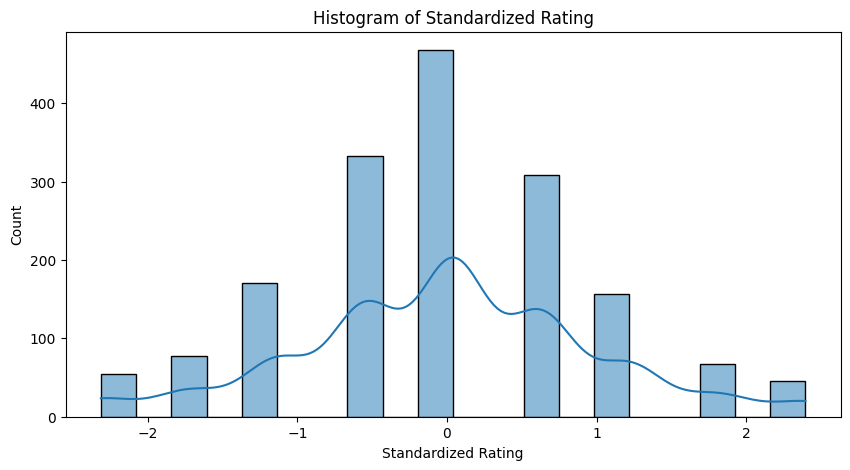

In [72]:
# Feature Scaling
scaler = MinMaxScaler()
df_5['Scaled Price'] = scaler.fit_transform(df_5[['Price in INR']])

plt.figure(figsize=(10,5))
sns.histplot(df_5['Scaled Price'], bins=20, kde=True)
plt.title("Histogram of Scaled Price")
plt.show()

standardizer = StandardScaler()
df_5['Standardized Rating'] = standardizer.fit_transform(df_5[['Rating']])

plt.figure(figsize=(10,5))
sns.histplot(df_5['Standardized Rating'], bins=20, kde=True)
plt.title("Histogram of Standardized Rating")
plt.show()

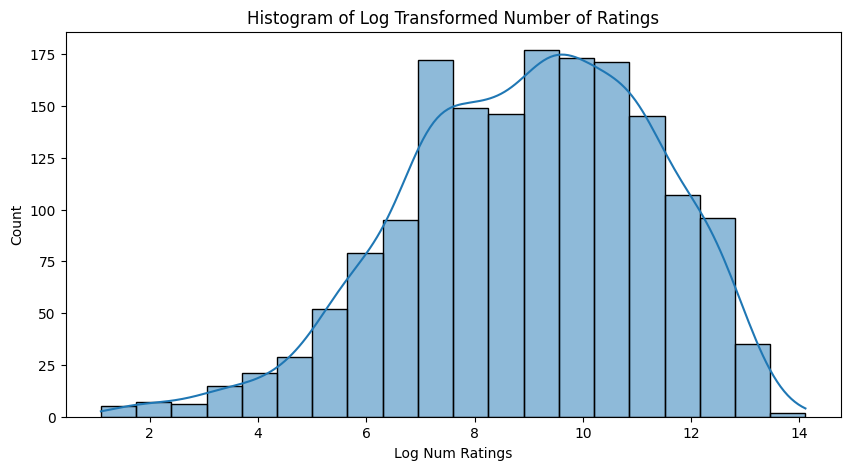

In [73]:
# Variable Transformation
df_5['Log Num Ratings'] = np.log1p(df_5['Number of Ratings'])

plt.figure(figsize=(10,5))
sns.histplot(df_5['Log Num Ratings'], bins=20, kde=True)
plt.title("Histogram of Log Transformed Number of Ratings")
plt.show()
